## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

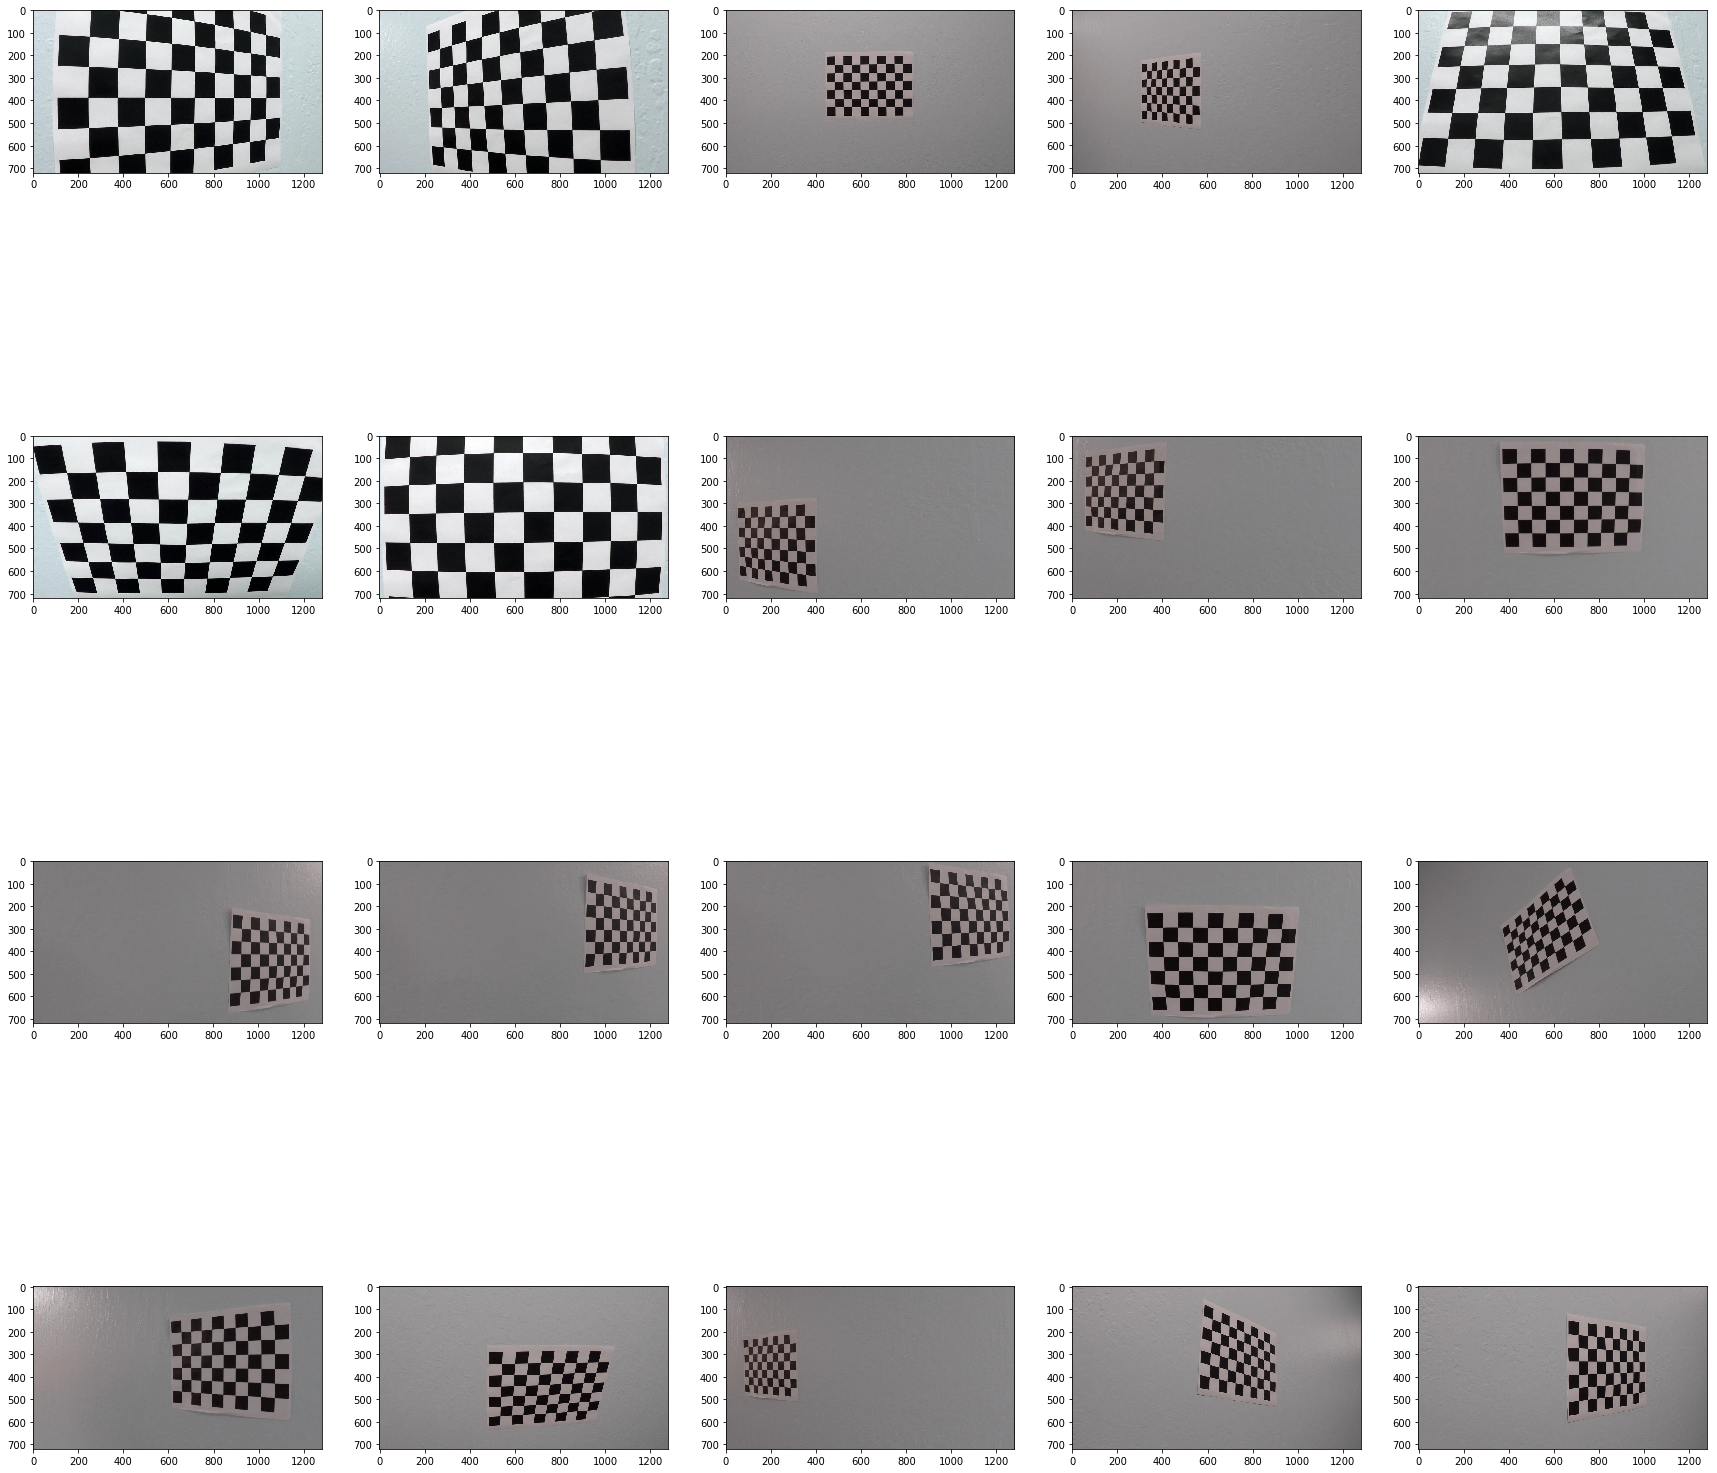

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = glob.glob('./camera_cal/calibration*.jpg')

n_pics = 20
plt.figure(n_pics, figsize=(30,30))
i=0;
for frame in images:
    img = cv2.imread(frame)
    # Draw and display the corners
    plt.subplot(4,5, i+1)
    plt.imshow(img)
    i+=1

20


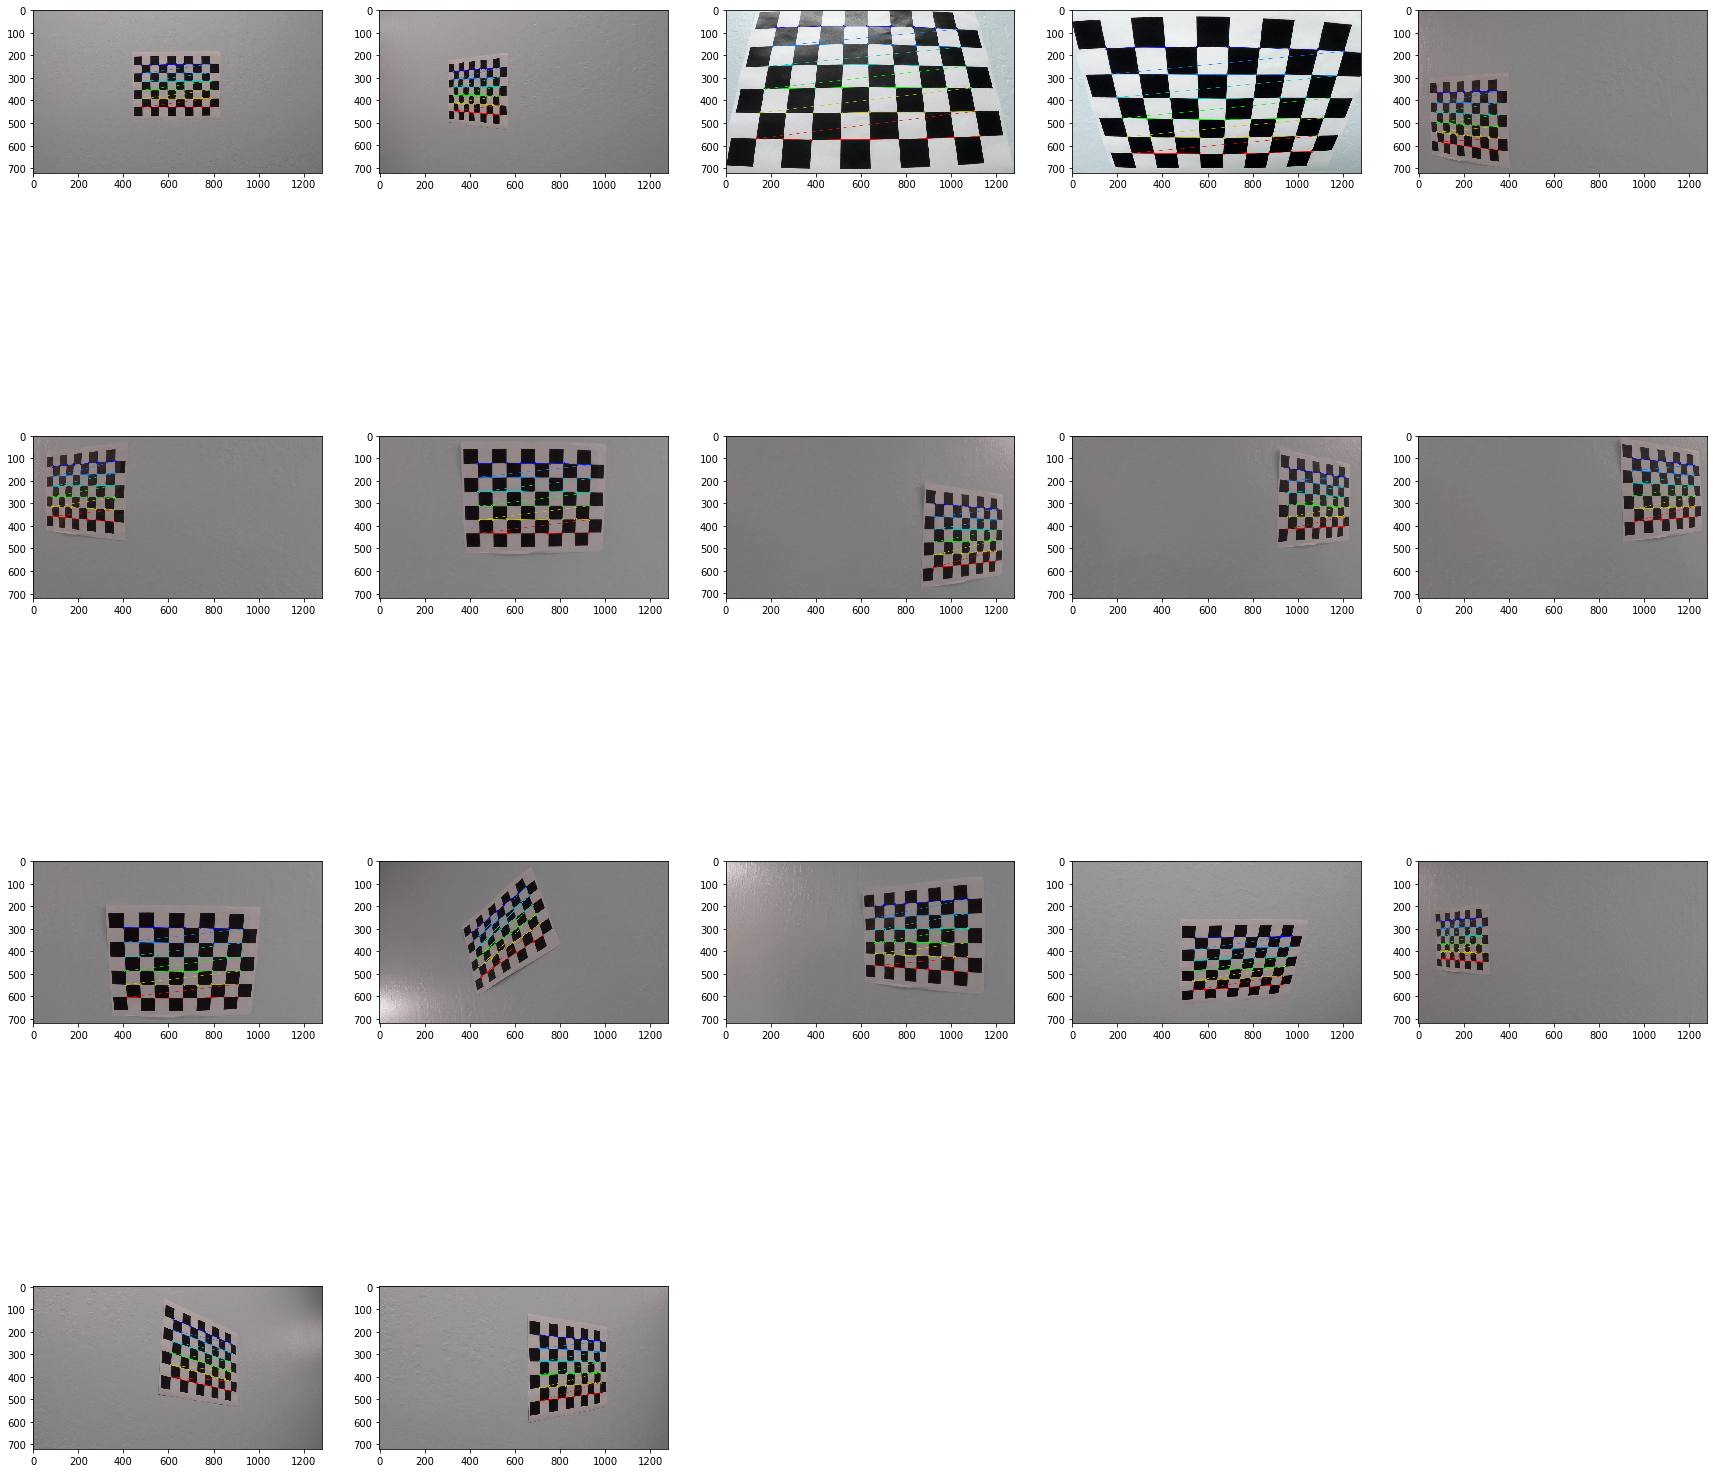

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
print(len(images))

# Step through the list and search for chessboard corners
n_pics = 20
plt.figure(n_pics, figsize=(30,30))
i=0;
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)    
        plt.subplot(4,5, i+1)
        plt.imshow(img)
        i+=1
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

## Functions

Text(0.5,1,'Undistorted Image')

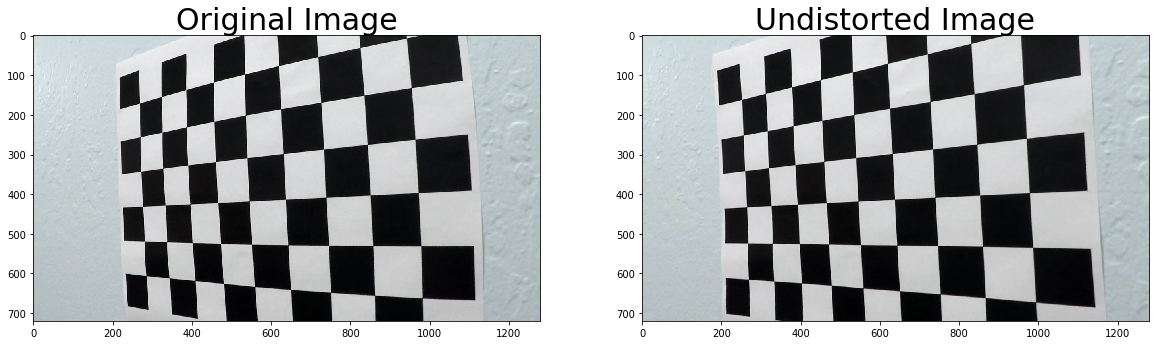

In [4]:
import pickle
%matplotlib inline

img = cv2.imread('camera_cal/calibration4.jpg')


img_size = (img.shape[1], img.shape[0])
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

cv2.imwrite('output_images/test_undist.jpg',dst)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "output_images/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [5]:
def true_img(img):
    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) 
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) 
    # 3) Calculate the magnitude 
    mag = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_mag = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag>=thresh[0]) & (scaled_mag<=thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) 
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) 
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction>=thresh[0]) & (direction<=thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# select s channel
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    sc = hls[:,:,2]
    binary_output = np.zeros_like(sc)
    binary_output[(sc > thresh[0]) & (sc <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

# select r channel
def rgb_select(img, thresh=(0, 255)):
    # 1) Apply a threshold to the R channel
    r_channel = img[:,:,0]
    binary_output = np.zeros_like(r_channel)
    binary_output[(r_channel > thresh[0]) & (r_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary[(sxbinary == 1) & (s_binary == 1)] = 1
    return color_binary
    


In [6]:
def pipeline(img, s_thresh=(170, 255), abs_thresh=(20, 130)):
    img = np.copy(img)
    s_binary = hls_select(img, thresh=s_thresh)
    abs_binary = abs_sobel_thresh(img, thresh=abs_thresh)
    #r_binary = rgb_select(img, thresh=(0,100))
    color_binary = np.dstack(( np.zeros_like(s_binary), s_binary, abs_binary)) * 255
    #color_binary = np.zeros_like(s_binary)
    color_binary[(s_binary == 1) & (abs_binary == 1)] = 1
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (abs_binary == 1)] = 1
    return combined_binary
    

In [7]:
image = mpimg.imread('test_images/test5.jpg')
undis = true_img(image)
result = pipeline(undis)

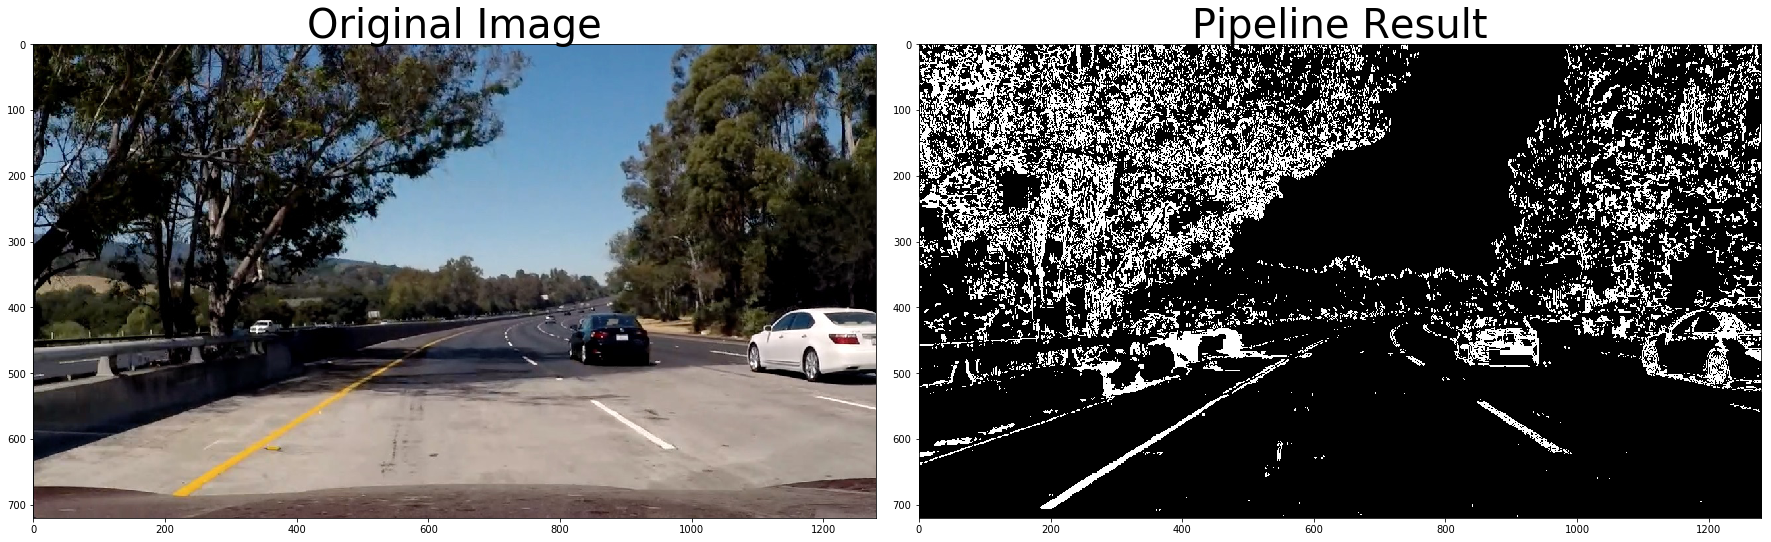

In [8]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform

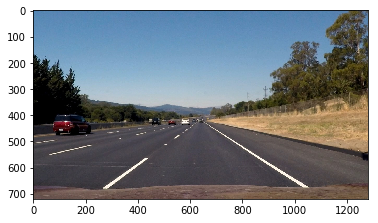

In [9]:
img = mpimg.imread('test_images/straight_lines2.jpg')
plt.figure()
plt.imshow(img)

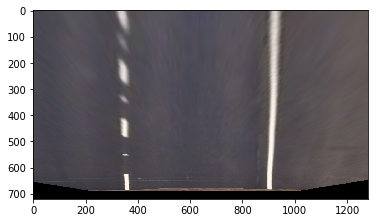

In [10]:
src = np.float32([[261, 680], [1041,680], [750, 492], [535, 492]])
dst = np.float32([[350, 680], [900,680],[900, 492], [350, 492]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
und = true_img(img)

def p_trans(img, M):
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
warped = p_trans(und, M)
plt.figure()
plt.imshow(warped)

### Now for curve lines

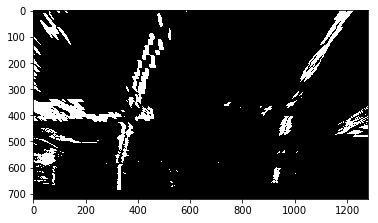

In [11]:
img = mpimg.imread('test_images/test5.jpg')
undis = true_img(img)
test_bin = pipeline(undis)
res = p_trans(test_bin, M)
plt.figure()
plt.imshow(res, cmap='gray')

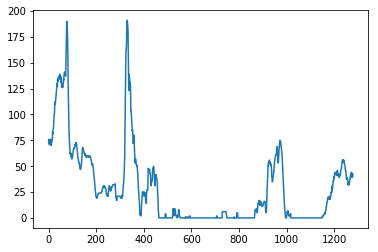

In [12]:
histogram = np.sum(res[res.shape[0]//2:,:], axis=0)
plt.plot(histogram)

### sliding window

(720, 0)

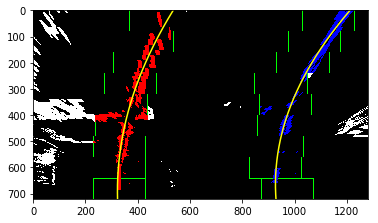

In [13]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((res, res, res))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(res.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = res.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = res.shape[0] - (window+1)*window_height
    win_y_high = res.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, res.shape[0]-1, res.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### skip binary search

In [14]:
binary_warped = res
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

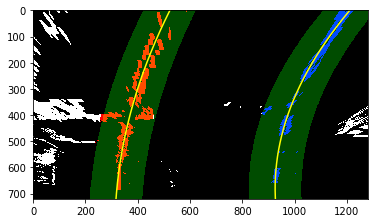

In [15]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### measuring curvature

In [16]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

1692.85024215 814.212643484


In [17]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

551.807499877 m 266.518014009 m


### Drawing

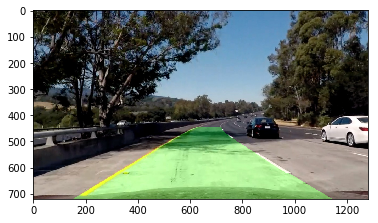

In [18]:
# Minv = cv2.getPerspectiveTransform(dst, src)
warped = res
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undis, 1, newwarp, 0.3, 0)
plt.imshow(result)

### Define functions to test on multiple images

## Video

In [307]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #if it is the first frame
        self.first_frame = True 
        self.max_len = 5
        self.bad_counter = 0
    def empty(self):
        while self.recent_xfitted:
            self.recent_xfitted.pop()
        return self.recent_xfitted
    def put(self, item):
        self.recent_xfitted.insert(0, item)
    def get(self):
        self.recent_xfitted.pop()
    def size(self):
        return len(self.recent_xfitted)
    def exceed_size(self):
        return len(self.recent_xfitted) > self.max_len
    def avg(self):
        return int(np.mean(self.recent_xfitted))
    def isEmpty(self):
        if not self.recent_xfitted:
            return True
        else:
            return False
    def save_offset(self, offset):
        self.line_base_pos = offset
    def line_detected(self):
        self.detected = True
    def not_detected(self):
        self.detected = False
    def set_curve(self, curve):
        self.radius_of_curvature = curve
    def update_best_fit(self):
        self.best_fit = np.mean(self.recent_xfitted, axis=0)
    def update_bestx(self, x):
        self.bestx = x

In [308]:


def slide_win(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit
    
def skip_slide(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fitx, right_fitx, ploty, left_fit, right_fit

def cal_width(poly_left, poly_right, max_len=1):
    random_point = np.random.randint(max_len, size=1)
    test_point = 30
    eq_left = np.poly1d(poly_left)
    eq_right = np.poly1d(poly_right)
    distance = eq_right(test_point) - eq_left(test_point)
    lane_mid = (eq_right(test_point) + eq_left(test_point))/2
    return distance, lane_mid

def cal_offset(lane_mid):
    # positive means right, negative means left
    return lane_mid - 640*3.7/700 

def measure_curve(left_fitx, right_fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    distance, lane_mid = cal_width(left_fit_cr, right_fit_cr)
    #print(distance)
    offset = cal_offset(lane_mid)
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad, offset
    
    
def draw_area(warped, undist, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    # plt.imshow(result)
    return result

# sanity check parts
def check_curvature(left_curverad, right_curverad, thresh = 300):
    if (abs(left_curverad - right_curverad) < thresh):
        return True
    else:
        return False
    
def check_dist(left_fitx, right_fitx, ploty, thresh=(2.5, 3.5), percent=0.8):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    total = len(ploty)
    valid = 0
    #print(left_fitx[0]*xm_per_pix, right_fitx[0]*xm_per_pix)
    for x1, x2, y in zip(left_fitx, right_fitx, ploty):
        dist = xm_per_pix*(x2 - x1)
        if (dist > thresh[0] and dist < thresh[1]):
            valid += 1
    if valid/total > percent:
        return True
    else:
        return False

# stol: 2nd order parameter tolerance, ftol: 1st order parameter tolerance, 
def check_parallel(left_fitx, right_fitx, ploty, stol=1e-03, ftol=0.5):
    left_fit = np.polyfit(ploty, left_fitx, 2)
    right_fit = np.polyfit(ploty, right_fitx, 2)
    second_order = np.isclose(left_fit[0], right_fit[0], rtol=stol, atol=stol)
    first_order = np.isclose(left_fit[1], right_fit[1], rtol=ftol, atol=ftol)
    return second_order and first_order

def generate_points(wraped, left_fit, right_fit):
    ploty = np.linspace(0, wraped.shape[0]-1, wraped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty


### Define a video pipeline

In [309]:
# original don't change
def precess_image(frame):
    # undistort frame
    undist = true_img(frame)
    # creates filters to generate binary lane line image
    binary = pipeline(undist)
    # perspective transform
    wraped = p_trans(binary, M)
    left_fit, right_fit = [], []
    # using sliding window to determine lane line pixels
    if(len(left_fit) <= 0 or len(right_fit) <= 0):
        left_fit, right_fit = slide_win(wraped)     
    # skipping sliding window for better performance    
    left_fitx, right_fitx, ploty, skip_left_fit, skip_right_fit = skip_slide(wraped, left_fit, right_fit)
    # measure curve length in meters
    left_len, right_len, offset = measure_curve(left_fitx, right_fitx, ploty)
    # sanity check
    bool_curve = check_curvature(left_len, right_len)
    bool_distance = check_dist(left_fitx, right_fitx, ploty)
    bool_curve = check_parallel(left_fitx, right_fitx, ploty)
    bool_sanity = bool_curve and bool_distance and bool_curve
    
    # draw lane line area
    result = draw_area(warped, undist, Minv, left_fitx, right_fitx, ploty)
    text1 = 'average curvature left: '+str((left_len+right_len)/2)
    text2 = 'offset: '+str(offset)
    text3 = 'Sanity: '+str(bool_sanity)
    cv2.putText(result, text1, (30,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result, text2, (30,90), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result, text3, (30,130), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    return result

In [310]:
# with class implementation ------------------------------
def precess_video(frame):
    # undistort frame
    undist = true_img(frame)
    # creates filters to generate binary lane line image
    binary = pipeline(undist)
    # perspective transform
    wraped = p_trans(binary, M)
    left_fit, right_fit = [], []
    # using sliding window to determine lane line pixels
    if(not left_line.detected):
        left_fit, right_fit = slide_win(wraped) 
        left_line.current_fit = left_fit
        right_line.current_fit = right_fit
        left_fitx, right_fitx, ploty = generate_points(wraped, left_fit, right_fit)
        left_line.allx = left_fitx
        left_line.ally = ploty
        right_line.allx = right_fitx
        right_line.ally = ploty
        
    else:
        # skipping sliding window for better performance  
        left_fit = left_line.current_fit
        right_fit = right_line.current_fit
        left_fitx, right_fitx, ploty, skip_left_fit, skip_right_fit = skip_slide(wraped, left_fit, right_fit)
        left_line.current_fit = skip_left_fit
        right_line.current_fit = skip_right_fit
        left_line.allx = left_fitx
        left_line.ally = ploty
        right_line.allx = right_fitx
        right_line.ally = ploty
    # measure curve length in meters
    left_fitx = left_line.allx
    right_fitx = right_line.allx
    ploty = left_line.ally
    left_len, right_len, offset = measure_curve(left_fitx, right_fitx, ploty)
    # sanity check
    bool_curve = check_curvature(left_len, right_len)
    bool_distance = check_dist(left_fitx, right_fitx, ploty)
    bool_curve = check_parallel(left_fitx, right_fitx, ploty)
    bool_sanity = bool_curve and bool_distance and bool_curve
    #print(bool_sanity)
    if (bool_sanity):
        left_line.line_detected()
        right_line.line_detected()
        if(left_line.exceed_size()):
            left_line.get()
            right_line.get()
        left_line.put(left_line.current_fit)
        right_line.put(right_line.current_fit)
        left_line.update_best_fit()
        right_line.update_best_fit()
        left_fitx, right_fitx, ploty = generate_points(wraped, left_line.best_fit, right_line.best_fit)
        left_line.update_bestx(left_fitx)
        right_line.update_bestx(right_fitx)
        left_line.bad_counter = 0
        #print(left_line.recent_xfitted)
    else:
        left_line.bad_counter += 1
        if(left_line.bad_counter > 3):
            left_line.not_detected()
            right_line.not_detected()
        
    # draw lane line area
    if(left_line.bestx is None):
        left_fitx = left_line.allx
        right_fitx = right_line.allx
    else:
        left_fitx = left_line.bestx
        right_fitx = right_line.bestx
    result = draw_area(warped, undist, Minv, left_fitx, right_fitx, ploty)
    text1 = 'average curvature left: '+str((left_len+right_len)/2)
    text2 = 'offset: '+str(offset)
    text3 = 'Sanity: '+str(bool_sanity)
    cv2.putText(result, text1, (30,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result, text2, (30,90), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result, text3, (30,130), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    return result

### test on images first

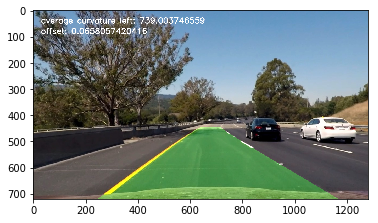

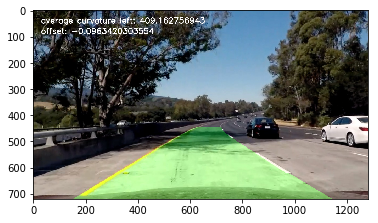

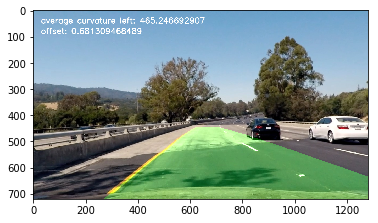

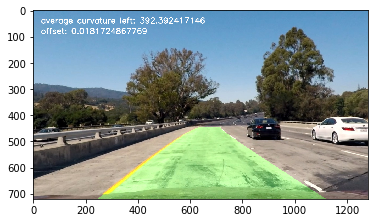

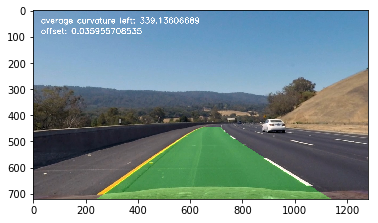

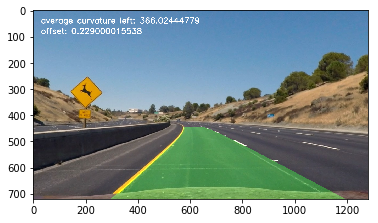

In [312]:

frames = glob.glob('test_images/test*.jpg')
for frame_path in frames:
    frame = mpimg.imread(frame_path)
    #print(frame.shape)
    test_frame = precess_image(frame)
    plt.figure()
    plt.imshow(test_frame)
    
#del left_line
#del right_line

In [313]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [314]:
left_line = Line()
right_line = Line()
left_line.detected = False

In [315]:
normal_output = 'output_videos/normal.mp4'

clip1 = VideoFileClip("project_video.mp4")
normal_clip = clip1.fl_image(precess_video) #NOTE: this function expects color images!!
%time normal_clip.write_videofile(normal_output, audio=False)

del left_line
del right_line

[MoviePy] >>>> Building video output_videos/normal.mp4
[MoviePy] Writing video output_videos/normal.mp4


100%|█████████▉| 1260/1261 [21:37<00:01,  1.15s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/normal.mp4 

CPU times: user 21min 18s, sys: 48.9 s, total: 22min 7s
Wall time: 21min 40s


In [303]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(normal_output))

### Challenge Video

In [305]:
left_line = Line()
right_line = Line()
left_line.detected = False

challenge_output = 'output_videos/challenge.mp4'

clip2 = VideoFileClip("challenge_video.mp4")
normal_clip = clip2.fl_image(precess_video) #NOTE: this function expects color images!!
%time normal_clip.write_videofile(challenge_output, audio=False)

del left_line
del right_line

[MoviePy] >>>> Building video output_videos/challenge.mp4
[MoviePy] Writing video output_videos/challenge.mp4


100%|██████████| 485/485 [07:39<00:00,  1.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge.mp4 

CPU times: user 7min 42s, sys: 13.7 s, total: 7min 56s
Wall time: 7min 41s


In [306]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [69]:
def check_width(poly_left, poly_right, max_len=10):
    random_point = np.random.randint(max_len, size=1)
    print(random_point[0])
    eq_left = np.poly1d(poly_left)
    eq_right = np.poly1d(poly_right)
    

1


In [266]:
a = np.array([[1, 2], [3, 4]])
print(len(a))

2


In [ ]:
vidcap = cv2.VideoCapture('challenge_video.mp4')
success,image = vidcap.read()
count = 0
index = 0
success = True
while success:  
    success,image = vidcap.read()
    print('Read a new frame: ', success)
    if(count % 10 ==0):
        cv2.imwrite("challenge_frames/frame%d.jpg" % index, image)     # save frame as JPEG file
        index += 1
    count += 1
    if(count > 60):
        success = False